In [18]:
import ROOT as r
import math
import array
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

#______________Add include directory_______________
current_dir = os.getcwd()
include_dir = os.path.join(current_dir, '../include')
sys.path.insert(0, include_dir)
#__________________________________________________

import CONFIG
import DBPARSE
from UTILITIES import *
from SIMFITS import DistributionFits
from ROOT import gStyle, TChain, TH1F, TCanvas, TLegend
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.optimize import curve_fit
from scipy.integrate import quad


In [19]:
pas="1"

# GEN2

Number of Total events: 218263
Number of Protons events: 15041
Number of Neutron events: 187156
Number of Background events: 16065
Fraction: fp=0.069 fbg=0.074


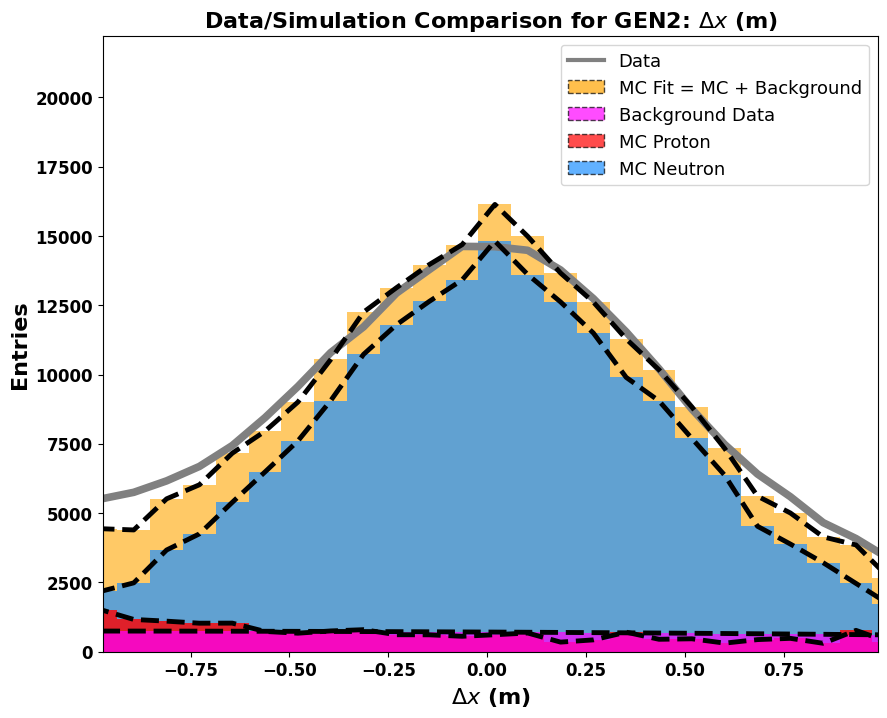

In [20]:
config="2"

save=np.load(f'SavedArrays/GEN{config}/Pass1/GEN{config}simfit1.npy',allow_pickle=True).item()

data=save['data']
bgHist=save['bgHist']
totalHist=save['totalHist']
simpHist=save['simpHist']
simnHist=save['simnHist']

sigCut=2
plt.figure(figsize=(10,8))
lw=3.5
fs=16
fw='bold'


#____________Data___________________________________________________________________________________________
bin_centers,bin_contents=data
plt.plot(bin_centers, bin_contents,'-',color='grey',linewidth=lw+2,label='Data')
#___________________________________________________________________________________________________________



#____________Total Fit = SimP + SimN + Background___________________________________________________________
bin_centers,bin_contents=totalHist
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.6,color='orange',label="Total Fit = bg+simN+simP")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
#___________________________________________________________________________________________________________



#____________Simulated Neutron______________________________________________________________________________
bin_centers,bin_contents=simnHist
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.7,color="dodgerblue",label="MC Neutron")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
#___________________________________________________________________________________________________________


#____________Simulated Proton_______________________________________________________________________________
bin_centers,bin_contents=simpHist
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.8,color="red",label="MC Proton")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
#___________________________________________________________________________________________________________

#____________Background_____________________________________________________________________________________
bin_centers,bin_contents=bgHist
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.7,color='magenta',label="Background Data")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
#___________________________________________________________________________________________________________



#____________________________vertical bars for quasi cut_____________________________________________-
#
bin_centers,bin_contents=simnHist

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

initial_guess = [max(bin_contents), bin_centers[np.argmax(bin_contents)], 1.0]

popt, pcov = curve_fit(gaussian, bin_centers, bin_contents, p0=initial_guess)

amplitude, mean, stddev = popt

x_fit = np.linspace(min(bin_centers), max(bin_centers), 100)
y_fit = gaussian(x_fit, *popt)
#plt.axvline(mean - sigCut * stddev, color='red', linewidth=4, label=f'$\mu - {sigCut}\sigma$')
#plt.axvline(mean + sigCut * stddev, color='red', linewidth=4, label=f'$\mu + {sigCut}\sigma$')
#________________________________________________________________________________________________________________
#_________________Special Legend Including Dotted Black Border______________________________________________
a=.7
legend_elements = [
    Line2D([0], [0], color='grey', linewidth=3, linestyle='-', label='Data'),
    Patch(facecolor='orange', edgecolor='black', linestyle='--', label='MC Fit = MC + Background', alpha=a),
    Patch(facecolor='magenta', edgecolor='black', linestyle='--', label='Background Data', alpha=a),
    Patch(facecolor='red', edgecolor='black', linestyle='--', label='MC Proton', alpha=a),
    Patch(facecolor='dodgerblue', edgecolor='black', linestyle='--', label='MC Neutron', alpha=a)
]
#___________________________________________________________________________________________________________
#plt.axvline(mean - sigCut * stddev, color='black', linewidth=3,ymax=.4,ymin=0.05,label=f'$\mu - {sigCut}\sigma$')
#plt.axvline(mean + sigCut * stddev, color='black', linewidth=3,ymax=.4,ymin=.05, label=f'$\mu + {sigCut}\sigma$')


#_________________________________Calculate Fractions_______________________
lower_bound = mean - sigCut * stddev
upper_bound = mean + sigCut * stddev

bin_centers,bin_contents=bgHist
numBG=np.sum(bin_contents[(bin_centers >= lower_bound) & (bin_centers <= upper_bound)])

bin_centers,bin_contents=simpHist
numProton=np.sum(bin_contents[(bin_centers >= lower_bound) & (bin_centers <= upper_bound)])

bin_centers,bin_contents=simnHist
numNeutron=np.sum(bin_contents[(bin_centers >= lower_bound) & (bin_centers <= upper_bound)])

bin_centers,bin_contents=totalHist
numTotal=np.sum(bin_contents[(bin_centers >= lower_bound) & (bin_centers <= upper_bound)])

#___________________________________________________________________________
plt.xlim((lower_bound,upper_bound))
plt.ylim((0,np.max(simnHist[1]*1.5)))
plt.title(f'Data/Simulation Comparison for GEN{config}: $\Delta x$ (m)',fontsize=fs,fontweight=fw)
plt.legend(handles=legend_elements,loc='upper right',fontsize=fs-3)
plt.xticks(fontsize=fs-4, fontweight=fw)
plt.yticks(fontsize=fs-4, fontweight=fw)
plt.xlabel(r'$\Delta x$ (m)',fontsize=fs,fontweight=fw)
plt.ylabel('Entries',fontsize=fs,fontweight=fw)

print(f'Number of Total events: {int(numTotal)}')
print(f'Number of Protons events: {int(numProton)}')
print(f'Number of Neutron events: {int(numNeutron)}')
print(f'Number of Background events: {int(numBG)}')
print(f'Fraction: fp={np.round(numProton/numTotal,3)} fbg={np.round(numBG/numTotal,3)}')
fproton=np.round(numProton/numTotal,3)
fbg=np.round(numBG/numTotal,3)
np.save(f'CorrectionArrays/Pass{pas}/fproton{config}.npy',np.array(fproton))
np.save(f'CorrectionArrays/Pass{pas}/fbg{config}.npy',np.array(fbg))

In [21]:




#def gaussian(x, amplitude, mean, stddev):
#    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

#initial_guess = [max(bin_contents), bin_centers[np.argmax(bin_contents)], 1.0]

#popt, pcov = curve_fit(gaussian, bin_centers, bin_contents, p0=initial_guess)

#amplitude, mean, stddev = popt

#plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.5, color="dodgerblue", label="MC Neutron")
#x_fit = np.linspace(min(bin_centers), max(bin_centers), 100)
#y_fit = gaussian(x_fit, *popt)
#plt.plot(x_fit, y_fit, color='grey', linewidth=4,alpha=.6, label='Gaussian Fit')
#plt.axvline(mean - sigCut * stddev, color='red', linewidth=4, label=f'$\mu - {sigCut}\sigma$')
#plt.axvline(mean + sigCut * stddev, color='red', linewidth=4, label=f'$\mu + {sigCut}\sigma$')

#plt.xlabel('$\Delta X$')
#plt.ylabel('Events')
#plt.title('MC Neutron Fit From Total Fitting Function')
#plt.legend()
#plt.show()
#lower_bound = mean - sigCut * stddev
#upper_bound = mean + sigCut * stddev
#within_3sigma = np.sum(bin_contents[(bin_centers >= lower_bound) & (bin_centers <= upper_bound)])
##print(f"Mean: {mean}, Standard Deviation (Sigma): {stddev}")
##print(f"Number of events within ±{sigCut}sigma: {within_3sigma}")

#bin_centers,bin_contents=simpHist
#within_3sigmap = np.sum(bin_contents[(bin_centers >= lower_bound) & (bin_centers <= upper_bound)])
#print(f"Number of Neutron events within ±{sigCut} sigma: {within_3sigma}")
#print(f"Number of Proton events within ±{sigCut} sigma: {within_3sigmap}")
#print(f"Percentage of Proton events inside ±{sigCut} sigma cut on neutrons: {100*within_3sigmap/within_3sigma}")

# GEN3

Number of Total events: 40717
Number of Protons events: 1558
Number of Neutron events: 13567
Number of Background events: 25592
Fraction: fp=0.038 fbg=0.629


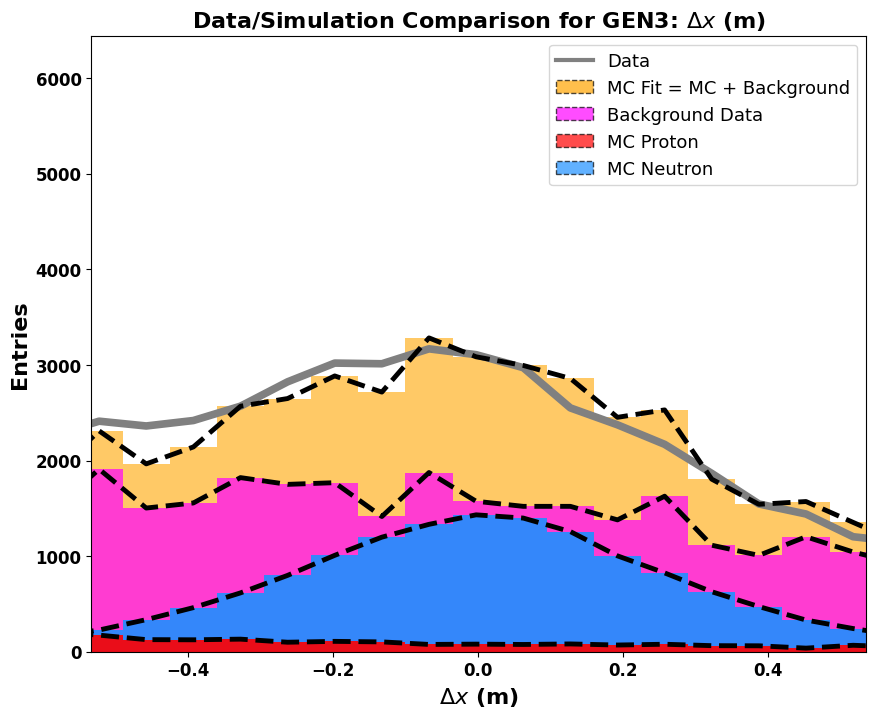

In [22]:
config="3"

save=np.load(f'SavedArrays/GEN{config}/Pass1/GEN{config}simfit1.npy',allow_pickle=True).item()

data=save['data']
bgHist=save['bgHist']
totalHist=save['totalHist']
simpHist=save['simpHist']
simnHist=save['simnHist']

sigCut=2
plt.figure(figsize=(10,8))
lw=3.5
fs=16
fw='bold'


#____________Data___________________________________________________________________________________________
bin_centers,bin_contents=data
plt.plot(bin_centers, bin_contents,'-',color='grey',linewidth=lw+2,label='Data')
#___________________________________________________________________________________________________________



#____________Total Fit = SimP + SimN + Background___________________________________________________________
bin_centers,bin_contents=totalHist
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.6,color='orange',label="Total Fit = bg+simN+simP")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
#___________________________________________________________________________________________________________





#____________Background_____________________________________________________________________________________
bin_centers,bin_contents=bgHist
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.7,color='magenta',label="Background Data")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
#___________________________________________________________________________________________________________

#____________Simulated Neutron______________________________________________________________________________
bin_centers,bin_contents=simnHist
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.9,color="dodgerblue",label="MC Neutron")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
#___________________________________________________________________________________________________________

#____________Simulated Proton_______________________________________________________________________________
bin_centers,bin_contents=simpHist
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.9,color="red",label="MC Proton")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
#___________________________________________________________________________________________________________


#____________________________vertical bars for quasi cut_____________________________________________-
#
bin_centers,bin_contents=simnHist

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

initial_guess = [max(bin_contents), bin_centers[np.argmax(bin_contents)], 1.0]

popt, pcov = curve_fit(gaussian, bin_centers, bin_contents, p0=initial_guess)

amplitude, mean, stddev = popt

x_fit = np.linspace(min(bin_centers), max(bin_centers), 100)
y_fit = gaussian(x_fit, *popt)
#plt.axvline(mean - sigCut * stddev, color='red', linewidth=4, label=f'$\mu - {sigCut}\sigma$')
#plt.axvline(mean + sigCut * stddev, color='red', linewidth=4, label=f'$\mu + {sigCut}\sigma$')
#________________________________________________________________________________________________________________
#_________________Special Legend Including Dotted Black Border______________________________________________
a=.7
legend_elements = [
    Line2D([0], [0], color='grey', linewidth=3, linestyle='-', label='Data'),
    Patch(facecolor='orange', edgecolor='black', linestyle='--', label='MC Fit = MC + Background', alpha=a),
    Patch(facecolor='magenta', edgecolor='black', linestyle='--', label='Background Data', alpha=a),
    Patch(facecolor='red', edgecolor='black', linestyle='--', label='MC Proton', alpha=a),
    Patch(facecolor='dodgerblue', edgecolor='black', linestyle='--', label='MC Neutron', alpha=a)
]
#___________________________________________________________________________________________________________
#plt.axvline(mean - sigCut * stddev, color='black', linewidth=3,ymax=.4,ymin=0.05,label=f'$\mu - {sigCut}\sigma$')
#plt.axvline(mean + sigCut * stddev, color='black', linewidth=3,ymax=.4,ymin=.05, label=f'$\mu + {sigCut}\sigma$')


#_________________________________Calculate Fractions_______________________
lower_bound = mean - sigCut * stddev
upper_bound = mean + sigCut * stddev

bin_centers,bin_contents=bgHist
numBG=np.sum(bin_contents[(bin_centers >= lower_bound) & (bin_centers <= upper_bound)])

bin_centers,bin_contents=simpHist
numProton=np.sum(bin_contents[(bin_centers >= lower_bound) & (bin_centers <= upper_bound)])

bin_centers,bin_contents=simnHist
numNeutron=np.sum(bin_contents[(bin_centers >= lower_bound) & (bin_centers <= upper_bound)])

bin_centers,bin_contents=totalHist
numTotal=np.sum(bin_contents[(bin_centers >= lower_bound) & (bin_centers <= upper_bound)])

#___________________________________________________________________________
plt.xlim((lower_bound,upper_bound))
plt.ylim((0,np.max(simnHist[1]*4.5)))
plt.title(f'Data/Simulation Comparison for GEN{config}: $\Delta x$ (m)',fontsize=fs,fontweight=fw)
plt.legend(handles=legend_elements,loc='upper right',fontsize=fs-3)
plt.xticks(fontsize=fs-4, fontweight=fw)
plt.yticks(fontsize=fs-4, fontweight=fw)
plt.xlabel(r'$\Delta x$ (m)',fontsize=fs,fontweight=fw)
plt.ylabel('Entries',fontsize=fs,fontweight=fw)

print(f'Number of Total events: {int(numTotal)}')
print(f'Number of Protons events: {int(numProton)}')
print(f'Number of Neutron events: {int(numNeutron)}')
print(f'Number of Background events: {int(numBG)}')
print(f'Fraction: fp={np.round(numProton/numTotal,3)} fbg={np.round(numBG/numTotal,3)}')
fproton=np.round(numProton/numTotal,3)
fbg=np.round(numBG/numTotal,3)
np.save(f'CorrectionArrays/Pass{pas}/fproton{config}.npy',np.array(fproton))
np.save(f'CorrectionArrays/Pass{pas}/fbg{config}.npy',np.array(fbg))

# GEN4

Number of Total events: 218263
Number of Protons events: 15041
Number of Neutron events: 187156
Number of Background events: 16065
Fraction: fp=0.069 fbg=0.074


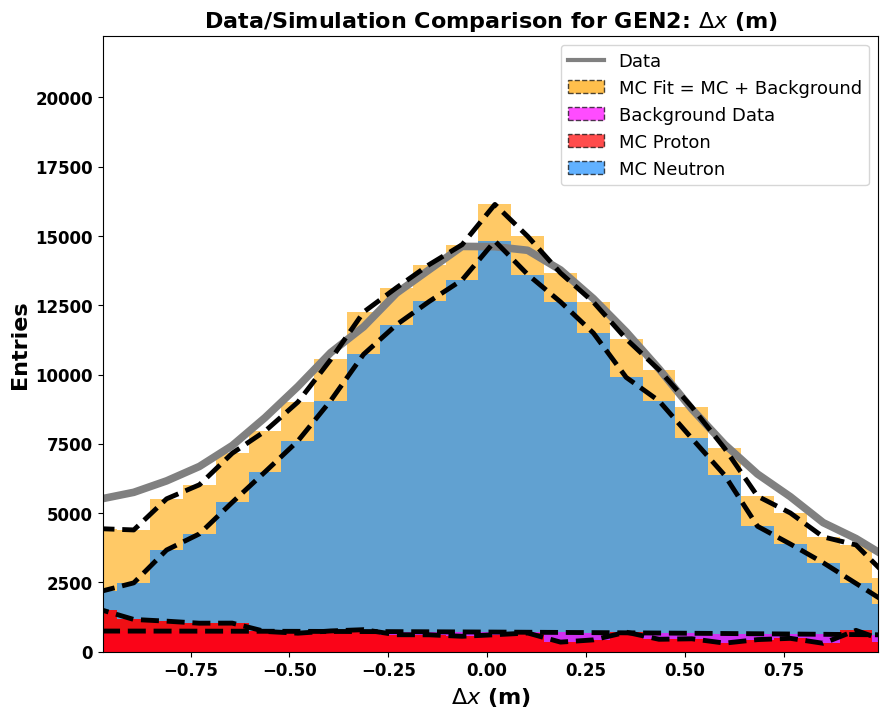

In [17]:
config="2"

save=np.load(f'SavedArrays/GEN{config}/Pass1/GEN{config}simfit1.npy',allow_pickle=True).item()

data=save['data']
bgHist=save['bgHist']
totalHist=save['totalHist']
simpHist=save['simpHist']
simnHist=save['simnHist']

sigCut=2
plt.figure(figsize=(10,8))
lw=3.5
fs=16
fw='bold'


#____________Data___________________________________________________________________________________________
bin_centers,bin_contents=data
plt.plot(bin_centers, bin_contents,'-',color='grey',linewidth=lw+2,label='Data')
#___________________________________________________________________________________________________________



#____________Total Fit = SimP + SimN + Background___________________________________________________________
bin_centers,bin_contents=totalHist
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.6,color='orange',label="Total Fit = bg+simN+simP")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
#___________________________________________________________________________________________________________



#____________Simulated Neutron______________________________________________________________________________
bin_centers,bin_contents=simnHist
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.7,color="dodgerblue",label="MC Neutron")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
#___________________________________________________________________________________________________________

#____________Background_____________________________________________________________________________________
bin_centers,bin_contents=bgHist
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.7,color='magenta',label="Background Data")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
#___________________________________________________________________________________________________________

#____________Simulated Proton_______________________________________________________________________________
bin_centers,bin_contents=simpHist
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.9,color="red",label="MC Proton")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
#___________________________________________________________________________________________________________


#____________________________vertical bars for quasi cut_____________________________________________-
#
bin_centers,bin_contents=simnHist

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

initial_guess = [max(bin_contents), bin_centers[np.argmax(bin_contents)], 1.0]

popt, pcov = curve_fit(gaussian, bin_centers, bin_contents, p0=initial_guess)

amplitude, mean, stddev = popt

x_fit = np.linspace(min(bin_centers), max(bin_centers), 100)
y_fit = gaussian(x_fit, *popt)
#plt.axvline(mean - sigCut * stddev, color='red', linewidth=4, label=f'$\mu - {sigCut}\sigma$')
#plt.axvline(mean + sigCut * stddev, color='red', linewidth=4, label=f'$\mu + {sigCut}\sigma$')
#________________________________________________________________________________________________________________
#_________________Special Legend Including Dotted Black Border______________________________________________
a=.7
legend_elements = [
    Line2D([0], [0], color='grey', linewidth=3, linestyle='-', label='Data'),
    Patch(facecolor='orange', edgecolor='black', linestyle='--', label='MC Fit = MC + Background', alpha=a),
    Patch(facecolor='magenta', edgecolor='black', linestyle='--', label='Background Data', alpha=a),
    Patch(facecolor='red', edgecolor='black', linestyle='--', label='MC Proton', alpha=a),
    Patch(facecolor='dodgerblue', edgecolor='black', linestyle='--', label='MC Neutron', alpha=a)
]
#___________________________________________________________________________________________________________
#plt.axvline(mean - sigCut * stddev, color='black', linewidth=3,ymax=.4,ymin=0.05,label=f'$\mu - {sigCut}\sigma$')
#plt.axvline(mean + sigCut * stddev, color='black', linewidth=3,ymax=.4,ymin=.05, label=f'$\mu + {sigCut}\sigma$')


#_________________________________Calculate Fractions_______________________
lower_bound = mean - sigCut * stddev
upper_bound = mean + sigCut * stddev

bin_centers,bin_contents=bgHist
numBG=np.sum(bin_contents[(bin_centers >= lower_bound) & (bin_centers <= upper_bound)])

bin_centers,bin_contents=simpHist
numProton=np.sum(bin_contents[(bin_centers >= lower_bound) & (bin_centers <= upper_bound)])

bin_centers,bin_contents=simnHist
numNeutron=np.sum(bin_contents[(bin_centers >= lower_bound) & (bin_centers <= upper_bound)])

bin_centers,bin_contents=totalHist
numTotal=np.sum(bin_contents[(bin_centers >= lower_bound) & (bin_centers <= upper_bound)])

#___________________________________________________________________________
plt.xlim((lower_bound,upper_bound))
plt.ylim((0,np.max(simnHist[1]*1.5)))
plt.title(f'Data/Simulation Comparison for GEN{config}: $\Delta x$ (m)',fontsize=fs,fontweight=fw)
plt.legend(handles=legend_elements,loc='upper right',fontsize=fs-3)
plt.xticks(fontsize=fs-4, fontweight=fw)
plt.yticks(fontsize=fs-4, fontweight=fw)
plt.xlabel(r'$\Delta x$ (m)',fontsize=fs,fontweight=fw)
plt.ylabel('Entries',fontsize=fs,fontweight=fw)

print(f'Number of Total events: {int(numTotal)}')
print(f'Number of Protons events: {int(numProton)}')
print(f'Number of Neutron events: {int(numNeutron)}')
print(f'Number of Background events: {int(numBG)}')
print(f'Fraction: fp={np.round(numProton/numTotal,3)} fbg={np.round(numBG/numTotal,3)}')
fproton=np.round(numProton/numTotal,3)
fbg=np.round(numBG/numTotal,3)
np.save(f'CorrectionArrays/Pass{pas}/fproton{config}.npy',np.array(fproton))
np.save(f'CorrectionArrays/Pass{pas}/fbg{config}.npy',np.array(fbg))